In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install imgaug

In [3]:
from argparse import ArgumentParser
from data import TGSTransform, TGSSaltDataset, collate_fn
import matplotlib.pyplot as plt
from train import LitUNet
import torch
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.nn.functional as F
from utils import calculate_mAP
import pandas as pd
import os

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

# Prepair Data

In [4]:
root_ds = 'dataset'
img_size_ori = 101

In [5]:
# df = pd.read_csv(os.path.join(root_ds, 'train.csv'), usecols=[0])
# total_sample = len(df.index)
# print('Numper of rows:', total_sample)

# train_size = int(0.8*total_sample)
# train_index, val_index = random_split(range(total_sample), [train_size, total_sample - train_size])

train_df = pd.read_csv('train.csv')
val_df = pd.read_csv('val.csv')

train_ds = TGSSaltDataset(root_ds, train_df, transforms=TGSTransform(augment=True, use_depth=False))
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment=False, use_depth=False))

print(len(train_ds), len(val_ds))

3200 800


In [6]:
img, mask = train_ds[0]
print(img.size(), mask.size())

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


In [7]:
train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collate_fn, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_fn)

# Training

In [8]:
tt_logger = TensorBoardLogger(save_dir='logs',
                             version='04',
                             name='iter01')
checkpoint_dir = os.path.join(tt_logger.log_dir, 'ckpt')
checkpoint_callback = ModelCheckpoint(dirpath=checkpoint_dir,
                                      save_top_k=1,
                                      verbose=False,
                                      monitor='metrics_mAP',
                                      mode='max',
                                      save_last=False,)

In [9]:
def parse_args(args=None):
    parser = ArgumentParser()
    parser = pl.Trainer.add_argparse_args(parser)
    parser = LitUNet.add_model_specific_args(parser)
    parser.add_argument('--seed', type=int, default=42)
    return parser.parse_args(args)

def main(args):
    pl.seed_everything(args.seed)
    model = LitUNet(**vars(args))    
    trainer = pl.Trainer.from_argparse_args(args, logger= tt_logger, checkpoint_callback=checkpoint_callback)
    return model, trainer

In [10]:
# add PROGRAM level args
program_args = """
      --seed 42
      """.split()
model_args = """
    --bilinear y
    --lr 3e-4
    --momentum 0.9
    --weight_decay 5e-4
    """.split()
 
# add all the available trainer options to argparse
# ie: now --gpus --num_nodes ... --fast_dev_run all work in the cli
#     --resume_from_checkpoint original_sgd_logs/bs_32/last.ckpt
trainer_args = """
    --max_epoch 50
    --gpus 1
    --progress_bar_refresh_rate 20
    --num_sanity_val_steps 0
""".split()
args = parse_args(program_args + model_args + trainer_args)

In [11]:
model, trainer = main(args)

Global seed set to 42
GPU available: True, used: True
TPU available: None, using: 0 TPU cores


In [12]:
model.model

AttUNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, mom

In [ ]:
trainer.fit(model, train_dl, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | model | AttUNet | 17.6 M
----------------------------------
17.6 M    Trainable params
0         Non-trainable params
17.6 M    Total params
70.471    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [11]:
torch.save(model.model.state_dict(), 'unet1.pth')

In [14]:
dl_iter = iter(val_dl)

torch.Size([8, 1, 101, 101])


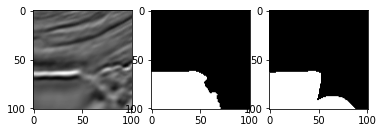

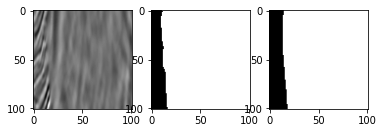

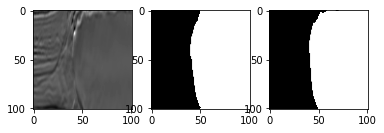

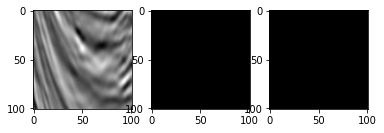

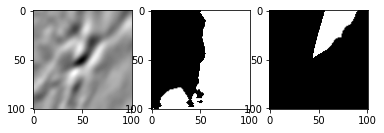

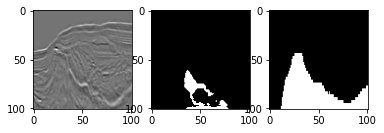

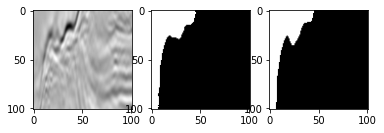

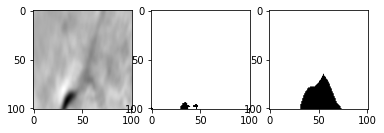

In [18]:
model.eval()
model.cuda()
with torch.no_grad():
    b = next(dl_iter)
    preds = F.sigmoid(model(b[0].cuda()))
    print(preds.size())
    for img, msk, pred_msk in zip(b[0], b[1], preds):
        _img = img[0].squeeze(0)
        _pred_msk = pred_msk.squeeze().cpu().numpy().round()
        _msk = msk.squeeze(0).round()
        fig,_ = plt.subplots(nrows=1, ncols=3)
        fig.axes[0].imshow(_img, cmap='gray')
        fig.axes[1].imshow(_pred_msk, cmap='gray')
        fig.axes[2].imshow(_msk, cmap='gray')
    plt.show()

torch.Size([8, 1, 101, 101])


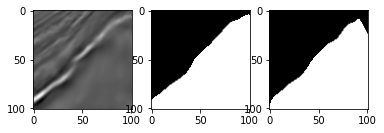

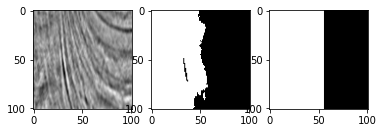

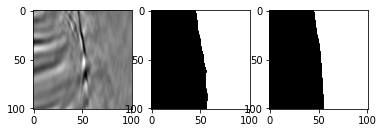

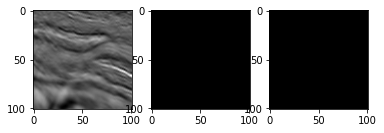

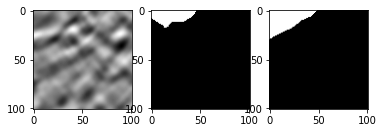

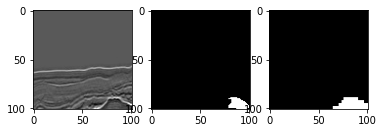

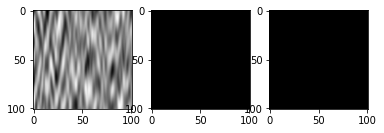

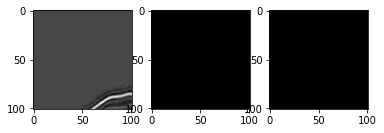

In [21]:
model.eval()
model.cuda()
with torch.no_grad():
    b = next(dl_iter)
    preds = F.sigmoid(model(b[0].cuda()))
    print(preds.size())
    for img, msk, pred_msk in zip(b[0], b[1], preds):
        _img = img[0].squeeze(0)
        _pred_msk = pred_msk.squeeze().cpu().numpy().round()
        _msk = msk.squeeze(0).round()
        fig,_ = plt.subplots(nrows=1, ncols=3)
        fig.axes[0].imshow(_img, cmap='gray')
        fig.axes[1].imshow(_pred_msk, cmap='gray')
        fig.axes[2].imshow(_msk, cmap='gray')
    plt.show()

torch.Size([8, 1, 101, 101])


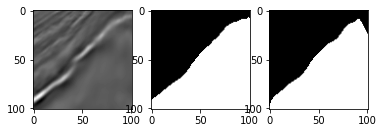

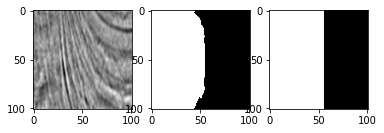

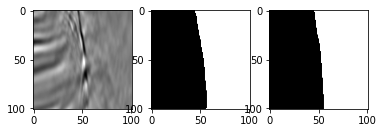

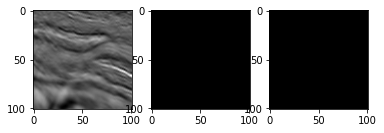

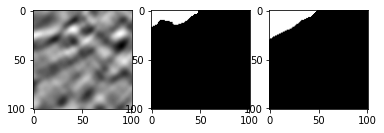

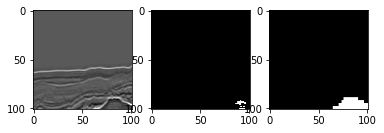

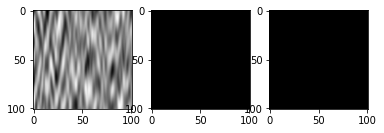

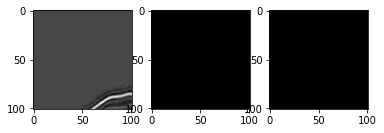

In [25]:
model.eval()
model.cuda()
with torch.no_grad():
    b = next(iter(dl))
    preds = F.sigmoid(model(b[0].cuda()))
    print(preds.size())
    for img, msk, pred_msk in zip(b[0], b[1], preds):
        _img = img[0].squeeze(0)
        _pred_msk = pred_msk.squeeze().cpu().numpy().round()
        _msk = msk.squeeze(0).round()
        fig,_ = plt.subplots(nrows=1, ncols=3)
        fig.axes[0].imshow(_img, cmap='gray')
        fig.axes[1].imshow(_pred_msk, cmap='gray')
        fig.axes[2].imshow(_msk, cmap='gray')
    plt.show()

In [12]:
img.shape

torch.Size([2, 101, 101])